In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.init as init
from time import time
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import numpy as np
import torchvision.utils as v_utils
import os 
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from math import sqrt
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Dataset Class

In [3]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms as transforms
import torch
import torchvision.datasets as datasets
class Dataset(Dataset):
  def __init__(self, x, y, n):
    self.x = torch.FloatTensor(x).view(n,1,28,28)
    self.y = torch.FloatTensor(y)

  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]


class Data:
  def __init__(self, config):
    self.normal_num = config['normal_num']
    if config['experiment_num'] == 1 or config['experiment_num'] == 3:
      self.ratio = 0.1
    elif config['experiment_num'] == 2 or config['experiment_num'] == 4:
      self.ratio = 0.01
    transform = Compose([ToTensor()])
    self.normal_num = config['normal_num']
    self.train_dataset, self.test_dataset = self.load_data(config['experiment_num'], config)

  def load_data(self, experiment_num, config):
    train_dataset = datasets.MNIST(root="../MNIST/processed/training.pt", train=True,  download=config['download'])
    train_x, train_y = train_dataset.data, train_dataset.targets
    test_dataset = datasets.MNIST(root="../MNIST/processed/test.pt", train=False,  download=config['download'])
    if experiment_num == 3 or experiment_num == 4:
      train_x, train_y = self.agumentation10(train_x, train_y)
    test_x, test_y = test_dataset.data, test_dataset.targets
    train_x, train_y = self.preprocessing(train_x, train_y, self.normal_num, self.ratio, True)
    test_x, test_y = self.preprocessing(test_x, test_y, self.normal_num, self.ratio, False)
    n = len(train_x)
    n_ = len(test_x)
    return Dataset(train_x, train_y, n), Dataset(test_x, test_y, n_)
 
  def agumentation10(self, x, y):
    trans_x = transforms.functional.affine(x, angle=0, translate=[0, 0], scale=1, shear=0)
    trans_y = y
    for trans in [[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [1, -1], [-1, 1], [-1,-1], [2, 0]]:
      temp = transforms.functional.affine(x, angle=0, translate=trans, scale=1, shear=0)
      trans_x = torch.cat([trans_x, temp])
      trans_y = torch.cat([trans_y, y])
    return trans_x, trans_y
   
  def preprocessing(self, x, y, normal_num, ratio, train):
    """
    Train Dataset에는 모두 0인 것만 포함시키기
    Test Dataset에는 0이 0.8개, 나머지는 0.2개를 포함시키기
    """
    # x = x/255.0
    x = x.float()
    x = (x-torch.min(x))/(torch.max(x)-torch.min(x))
    N = len(x)
    processing_x = []
    processing_y = []
    for i in range(N):
      if y[i] == normal_num:
        processing_x.append(x[i].reshape(-1).tolist())
        processing_y.append([y[i].tolist()])
    num_normal_data = len(processing_x)
    print("number of normal data: {}".format(num_normal_data))
    i = 0
    while(1):
      if train:
          break
      if len(processing_x) > num_normal_data*(1+self.ratio):
        break
      if y[i] != normal_num:
        processing_x.append(x[i].reshape(-1).tolist())
        processing_y.append([y[i].tolist()])
      i += 1
    print("number of abnormal data: {}".format(len(processing_x)-num_normal_data))
    return processing_x, processing_y

number of normal data: 5923
number of abnormal data: 0
number of normal data: 980
number of abnormal data: 99


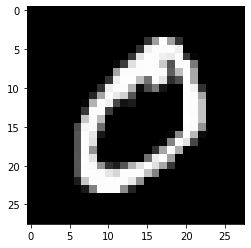

In [4]:
config = {
        "normal_num": 0,
        "ratio": 0.1,
        "batch_size": 63,
        'epoch': 200,
        'learning_rate': 0.0002,
        "experiment_num": 1,
        'use_save_model': False,
        'lambda':0.001,
        'normalization' : 'min_max',
        'download': False # MNIST를 다운할 것인지
}
data =Data(config)
train_loader = torch.utils.data.DataLoader(dataset=data.train_dataset,batch_size=config['batch_size'],shuffle=True,drop_last=True)
plt.imshow(train_loader.dataset.x[0][0],cmap='gray')
plt.show()


## Discriminator와 Generator Class

In [5]:

import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self,config):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature
        
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out


In [6]:
start = timer()
generator = Generator().cuda()
discriminator = Discriminator(config).cuda()
print("GPU의 할당시간 : {:4f}".format(timer()-start))
# try:
#     generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
#     discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
#     print("\n--------model restored--------\n")
# except:
#     print("\n--------model not restored--------\n")
#     pass

GPU의 할당시간 : 4.661761


In [7]:
loss_func = nn.MSELoss()

ones_label = torch.ones(config['batch_size'],1).cuda()
zeros_label = torch.zeros(config['batch_size'],1).cuda()

gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*config['learning_rate'],betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=config['learning_rate'],betas=(0.5,0.999))

In [8]:
def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(1):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## Main 부분

0th iteration gen_loss: 0.11460563540458679 dis_loss: 0.7331548929214478
Time : 47.143088


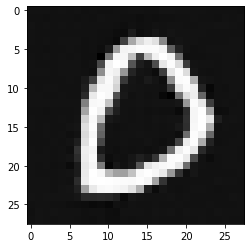

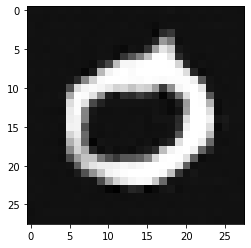

In [9]:
start = timer()
max_loss = 10000000.0
max_count = 15
cur_count = 0
generator.train()
discriminator.train()
for i in range(config['epoch']):
    total_loss = 0.0
    for j,(image,label) in enumerate(train_loader):
        image = image.cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = init.normal_(torch.Tensor(config['batch_size'],100).cuda(),mean=0,std=0.1)
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(config['batch_size'],100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
        total_loss += (gen_loss.detach().item()+ dis_loss.detach().item())
        # model save
        if i % 20 == 0 and j==0:
              #print(gen_loss,dis_loss)
              print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            
    # Early Stop 용도
    if total_loss < max_loss:
      max_loss = total_loss
      cur_count = 0
    else:
      cur_count += 1
      if cur_count == max_count:
        torch.save(generator.state_dict(),'saved_model/generator.pkl')
        torch.save(discriminator.state_dict(),'saved_model/discriminator.pkl')
        v_utils.save_image(gen_fake.data[0:25],"result/gen_{}_{}.png".format(i,j), nrow=5)
        break
      
print("Time : {:4f}".format(timer()-start))
image_check(gen_fake.cpu())

In [10]:
def Anomaly_score(x,G_z,Lambda=0.1):
    _,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z))
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [11]:
z = Variable(init.normal(torch.zeros(len(data.test_dataset),100).cuda(),mean=0,std=0.1),requires_grad=True)
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z)
test_data =  data.test_dataset.x.view(-1,1,28,28).cuda()
loss = Anomaly_score(test_data,gen_fake)

ipykernel_launcher:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [12]:
start = timer()
for i in range(5000):
    z_optimizer.zero_grad()
    gen_fake = generator(z)
    loss = Anomaly_score(test_data,gen_fake,Lambda=0.01)
    loss.backward()
    z_optimizer.step()
    
    if i%1000==0:
        print(loss.cpu().data)
print("Time : {:4f}".format(timer()-start))

tensor(154956.9375)
tensor(52035.3750)
tensor(41017.6484)
tensor(36278.3398)
tensor(33601.7773)
Time : 364.232439


In [13]:
gen_fake = generator(z)

_,x_feature = discriminator(test_data)
_,G_z_feature = discriminator(gen_fake)
test_flatten = test_data.view(test_data.shape[0],-1)
gen_fake_flatten = gen_fake.view(gen_fake.shape[0],-1)
resiudal_loss = torch.sum(torch.abs(test_flatten-gen_fake_flatten), axis = 1)
disc_loss = torch.sum(torch.abs(x_feature-G_z_feature), axis = 1)
total_loss = (1-config['lambda'])*resiudal_loss + config['lambda']*disc_loss

In [14]:
y = data.test_dataset.y.numpy().squeeze(1)
total_loss = total_loss.detach().cpu().numpy()
zero = y==0.
nonzero = y!=0.
dat = np.vstack([y,resiudal_loss.detach().cpu().numpy()]).T
df = pd.DataFrame(dat, columns = ['y', 'residual'])
df['y'] = df['y'].apply(lambda x:1 if x!=0.0 else 0)
df['total_loss'] = total_loss
df['disc_loss'] = disc_loss.detach().cpu().numpy()

In [15]:
print("Discrimination의 Anomaly score : {:4f}".format(np.mean(df[df['y']==1]['disc_loss'])))
print("Discrimination의 Normal score : {:4f}".format(np.mean(df[df['y']==0.0]['disc_loss'])))
print("Residual Anomaly score : {:4f}".format(np.mean(df[df['y']==1]['residual'])))
print("Residual Normal score : {:4f}".format(np.mean(df[df['y']==0.0]['residual'])))

Discrimination의 Anomaly score : 838.357666
Discrimination의 Normal score : 447.587036
Residual Anomaly score : 50.681759
Residual Normal score : 22.497726


## 표준화

In [42]:
    if config['normalization'] == 'standard':
        disc_mean = np.mean(df['disc_loss'])
        disc_std = np.std(df['disc_loss'], ddof = 1)
        score_mean = np.mean(df['residual'])
        score_std = np.std(df['residual'], ddof = 1)
        df['residual'] = (df['residual'] - score_mean) / score_std
        df['disc_loss'] = (df['disc_loss'] - disc_mean) / disc_std
    else:
        disc_min = np.min(df['disc_loss'])
        disc_max = np.max(df['disc_loss'])
        score_min = np.min(df['residual'])
        score_max = np.max(df['residual'])
        df['residual'] = (df['residual'] - score_min) / (score_max-score_min)
        df['disc_loss'] = (df['disc_loss'] - disc_min) / (disc_max - disc_min)


## Ratio에 따른 Metric 결과

In [16]:

ratio = [0,0.0001, 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999, 1]
disc_r, res_r, thres,au, re, pre, f1 = [],[],[],[],[],[],[]
for r in ratio:
    df['ano_score'] = (1-r)* df['residual'] + r*df['disc_loss']
    fpr, tpr, thresholds = metrics.roc_curve(df['y'].tolist(), df['ano_score'].tolist(), pos_label=1)
    dist = []
    min_idx = -1
    min_dist = 1000.0
    for i in range(len(fpr)):
        distance = sqrt((fpr[i]-0.0)**2 + (tpr[i]-1.0)**2)
        dist.append(distance)
        if distance < min_dist:
            min_idx = i
            min_dist = distance
    df['predict_y'] = df['ano_score'].apply(lambda x:1 if x>thresholds[min_idx] else 0)
    TN, FP, FN, TP = confusion_matrix(df['y'].tolist(), df['predict_y'].tolist(), labels = [0,1]).ravel()
    auc = metrics.auc(fpr, tpr)
    eps = 10e-5
    precision = TN/(TN+FN+eps)
    recall = TN/(TN+FP+eps)
    f1score = (2*precision*recall)/(precision+recall)
    disc_r.append(r)
    res_r.append(1-r)
    au.append(auc)
    re.append(recall)
    pre.append(precision)
    f1.append(f1score)
    thres.append(thresholds[min_idx])
metric = pd.DataFrame(np.asarray([disc_r,res_r, thres, au,re,pre,f1]).T, columns = ['Dis Ratio', 'Residual', 'Threshold','AUC', 'Recall', 'Precision', 'F1'])
idx = np.argmax(au)
df['ano_score'] = (1-ratio[idx])* df['residual'] + ratio[idx]*df['disc_loss']
threshold = thres[idx]


In [17]:
print(metric)

    Dis Ratio  Residual   Threshold       AUC    Recall  Precision        F1
0      0.0000    1.0000   31.720272  0.958225  0.919388   0.989023  0.952935
1      0.0001    0.9999   31.789379  0.958266  0.919388   0.989023  0.952935
2      0.0010    0.9990   32.326099  0.958545  0.919388   0.989023  0.952935
3      0.1000    0.9000   91.620491  0.963245  0.929592   0.992375  0.959958
4      0.2000    0.8000  146.086929  0.962915  0.917347   0.993370  0.953846
5      0.3000    0.7000  202.187866  0.962729  0.917347   0.993370  0.953846
6      0.4000    0.6000  260.410553  0.962564  0.919388   0.992291  0.954449
7      0.5000    0.5000  316.051025  0.962420  0.915306   0.992257  0.952229
8      0.6000    0.4000  371.691498  0.962317  0.913265   0.992239  0.951116
9      0.7000    0.3000  434.948883  0.962162  0.920408   0.991209  0.954497
10     0.8000    0.2000  492.170319  0.962008  0.920408   0.991209  0.954497
11     0.9000    0.1000  549.391663  0.962018  0.919388   0.991199  0.953944

## AUC 구하기 그래프

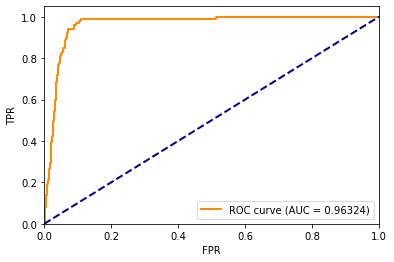

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(df['y'].tolist(), df['ano_score'].tolist(), pos_label=1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {})'.format(round(metrics.auc(fpr, tpr), 5)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.show()

## False Positive의 사진 확인

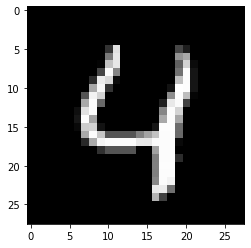

real data


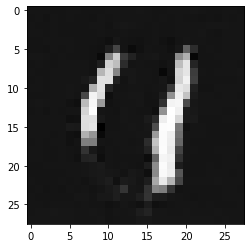

generated data

------------------------------------



In [25]:
indx = df[(df['y']==1)&(df['ano_score']<threshold)].iloc[0:1,:]
for idx in indx.index:
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")

## False Negative 사진

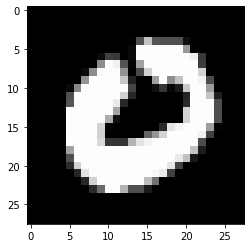

real data


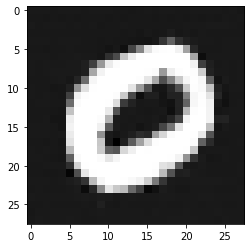

generated data

------------------------------------



In [24]:
indx = df[(df['y']==0)&(df['ano_score']>threshold)].iloc[0:1,:]
for idx in indx.index:
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")

## 0이 아닌 이미지 Generate

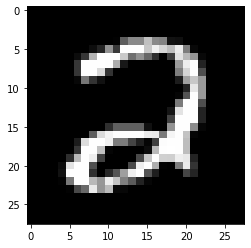

real data


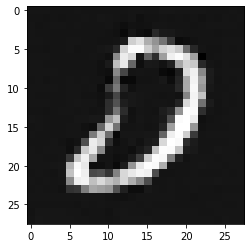

generated data

------------------------------------



In [23]:
n = len(data.test_dataset.y)
for idx in range(n-2,n-1):
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")

## Test에서 0인 데이터 Generate

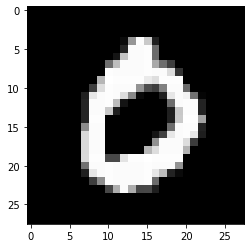

real data


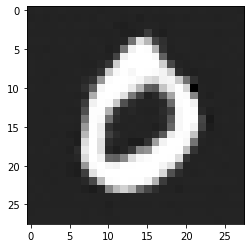

generated data

------------------------------------



In [22]:
for idx in range(0,1):
    target = test_data[idx,0,:,:]
    plt.imshow(target.cpu().numpy(),cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:]
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")